# Least Squares Monte Carlo: Longstaff and Schwartz (2001)

 Monte Carlo methods is a popular choice to calculate the value for most types of options, but they struggle with early exercise. This is the subject of lots of research at the moment and we have seen the basic idea of some of the methods. What we present here is one of the easiest methods to understand and implement. There are still issues with how it performs in practise which we will also deal with here. The key issue is: _How to find what is the expected value for continuation?_ The continuation value is the discounted expected option value at the next instance in time.

The Longstaff and Schwartz method estimates the conditional expected option value by:

- simulating lots of paths
- carrying out a regression analysis on the resulting option values

This gives an approximation for the continuation value that can then be compared to the early exercise value and then we know the option value at each point in time on each path. In terms of Monte Carlo pricing, all we actually need to know is the rule for early exercising, so we know when we receive the 
cash flows and the value of the option is the average of the discounted payoffs for each path.

We will explain the method via an example and then describe the general method. First we need to include a number of libraries in our code...

In [1]:
#include "../include/math60082_leastSquaresFit.hpp"
#include "../include/math60082_randomPaths.hpp"
#include "../include/math60082_monteCarloLeastSquares.hpp"
#include <vector>
#include <iostream>
#include <random>

In [2]:
.L boost_system  

In [3]:
.L ../lib/libmath60082.so

In [4]:
.L libgsl.so 

In [5]:
.L libcblas.so

In [6]:
#include "math60082_gnuplot_image.hpp"

In [7]:
// number of exercise dates
int timeSteps;
// some parameters in the problem
double maturity,interestRate,strikePrice,S0,sigma;
// local parameters
double dt=maturity/timeSteps;
// number of paths n
int n;
// degree of fitting polynomial
int M_degree;
std::vector< std::vector<double> > paths;
std::vector<int> exercisePeriod;
std::vector<MATH60082::DataPoint> data;
MATH60082::LeastSquaresFit V;
std::vector<double> t;

We will attempt to value a Bermudan put option where exercise is possible now and at three future dates. We choose
$S_0 = 1$, $X = 1.1$, $r = 0.06.$

The first step is to simulate some paths, we choose the same 8 paths that are used in the paper to demonstrate the method.

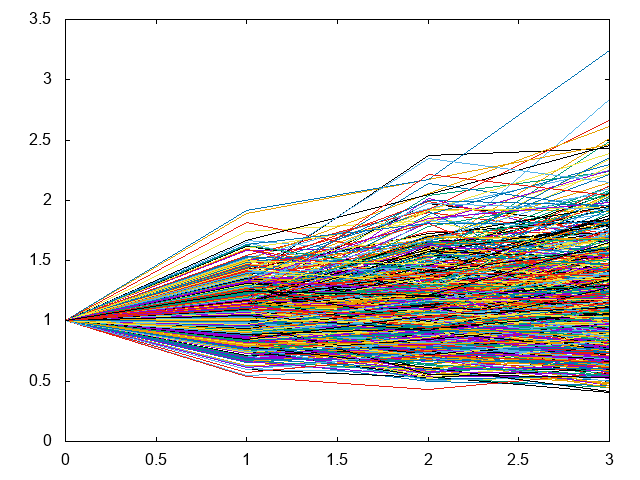

In [8]:
// number of exercise dates
timeSteps=3;
// some parameters in the problem
maturity=3.;
interestRate=0.06;
strikePrice=1.1;
M_degree=2;
// local parameters
dt=maturity/timeSteps;
// number of paths n
n=800;
S0=1.;
sigma=0.2;
// the paths as given in Longstaff & Schartz (2001)
//paths = MATH60082::generateLongstaffPaths(timeSteps,dt,n);
// later we might want to make these random
paths=MATH60082::generateRandomPaths(timeSteps,S0,dt,interestRate,sigma,n);
// plot the figure
{
    t.resize(timeSteps+1);
    for(int i=0;i<=timeSteps;i++)
    {
        t[i] = i*dt;
    }
    // put the plot in figure1
    GPLT::figure = GPLT::G.plotData(t,paths,0);
}
// show figure
GPLT::figure

Each of the 8 paths are plotted. We can see for instance that the light blue line is path number 3 from the paper.

We need to use this information to determine the continuation value at each point in time for each path. To do this we will construct a "Cash Flow Matrix" at each point in time. The table below denotes the cash flows at $t=3$ assuming that we held the option that far:

| Path |  t=1  |  t=2  |  t=3  |
|------|-------|-------|-------|
|1     |     - |     - |   .00 |
|2     | -     | -     | .00   |
|3     | -     | -     | .07   |
|4     | -     | -     | .18   |
|5     | -     | -     | .00   |
|6     |     - | -     | .20   |
|7     |     - | -     | .09   |
|8     |     - | -     | .00   |

At the moment we assume that all the paths are exercised at $t=3$. We need to keep track of when a path is exercised so store this in a vector.

In [9]:
// all paths initially exected to be exercised at expiry
exercisePeriod = std::vector<int>(n,timeSteps);

The next step is to attempt to find a function that describes the continuation value at time 2 as a function of the value of $S$ at time 2. To do this we use a regression technique, that takes the values at time 2 as the "$x$" values and the discounted payoff at time 3 as the "$y$" values.

| Path |   y                 |  x   |
|------|---------------------|------|
| 1    |  $.00\times .94176$ | 1.08 | 
| 2    | -                   | -    | 
| 3    | $.07\times .94176$  | 1.07 | 
| 4    | $.18\times .94176$  |  .97 | 
| 5    | -                   | -    | 
| 6    | $.20\times .94176$  |  .77 | 
| 7    | $.09\times .94176$  |  .84 | 
| 8    | -                   | -    | 

We put each of these values into a vector of type `MATH60082::DataPoint`, including only values where $S<X$.

In [10]:
// create an empty set of data points
data.clear();
data.reserve(n);
// go through each path, check if it is in the money
// if it is add it as a datapoint with appropriate payoff
for(int i=0;i<n;i++)
{
    if(paths[i][timeSteps-1]<strikePrice)
    {
        data.push_back({paths[i][timeSteps-1],std::max(strikePrice - paths[i][timeSteps],0.)*exp(-interestRate*dt),1.});
    }
}

Check the values in `data` match those from the table

In [11]:
std::cout << "# Points for fitting\n x_i  y_i \n";
for(auto di : data)
    std::cout << di.x << " " << di.y << "\n";

# Points for fitting
 x_i  y_i 
1.08072 0
0.769869 0.312969
0.974462 0.0788212
1.00225 0
0.572994 0.560112
0.814079 0.332301
0.813776 0.532535
1.09519 0.0804715
1.09323 0
0.90881 0.120492
0.574721 0.585251
0.957791 0.352431
0.696614 0.117456
0.771855 0.207277
0.602635 0.647435
1.05021 0.0857015
1.03414 0.131411
0.98552 0.444496
1.04319 0.0318943
0.830203 0.272054
0.750746 0.307952
0.81741 0.170301
0.918698 0.392641
0.892031 0.492073
0.867359 0
0.982566 0.168744
0.996078 0
1.05136 0
0.888918 0.171482
1.02061 0
1.01257 0.0727049
0.954792 0.189758
1.07219 0
0.972076 0
0.953927 0.312866
0.686794 0.287809
0.779378 0.434566
1.05586 0
0.882585 0
0.870173 0.255011
0.877995 0
0.91279 0.265445
0.837559 0.231978
0.590277 0.578716
0.725365 0.470994
1.09601 0
0.534324 0.617153
0.786749 0.128384
1.0957 0
0.799101 0.089946
0.871273 0.319168
0.812266 0.31865
1.00232 0.0237313
1.07167 0.0337954
1.06105 0.108396
1.09684 0
0.57054 0.302753
0.861587 0.15733
0.733481 0.188298
0.903987 0.158577
1.07717 0.12

Now perform the regression using `MATH60082::LeastSquaresFit`. We use `M_degree=2` so that it is a simple regression upon
$ x$ and $x^2$.

In [12]:
// get the continuation function
V.generateFit(M_degree,data);
std::cout << V << "\n";

 LeastSquaresFit of degree 2 valid over the range x\in[0.430058:1.099] :: {  Chebyshev polynomial degree 2 :: { 0.304887 -0.29293 0.0201468 } } which gives a range of the function  f\in[0.617964:0.032104]
# covariance matrix:
 0.00926023  -0.0115176  0.00793974 
 -0.0115176  0.0217009  -0.0107403 
 0.00793974  -0.0107403  0.0119079 
# chisq = 6.67359



To give you an idea of what this looks like, plot this regression function out against plotted data points. 

# fitted estimation 
  x_i 	   y_i  	 V(x_i) 
0.430058	 0.497743	 0.617964
0.494159	 0.602224	 0.547859
0.506774	 0.524878	 0.534412
0.508516	 0.524056	 0.532564
0.510876	 0.523471	 0.530064
0.524688	 0.381322	 0.515512
0.526779	 0.378844	 0.513321
0.532411	 0.463636	 0.507435
0.534324	 0.617153	 0.505441
0.535952	 0.652771	 0.503747
0.542388	 0.527485	 0.497066
0.546593	 0.228863	 0.492716
0.555806	 0.53249	 0.483232
0.567419	 0.18316	 0.471363
0.57054	 0.302753	 0.46819
0.571876	 0.413064	 0.466834
0.572994	 0.560112	 0.4657
0.574721	 0.585251	 0.463951
0.579614	 0.515141	 0.459005
0.58908	 0.227865	 0.449486
0.590277	 0.578716	 0.448286
0.594544	 0.468249	 0.44402
0.594972	 0.438866	 0.443593
0.600067	 0.476683	 0.438518
0.601749	 0.420966	 0.436847
0.602519	 0.319579	 0.436082
0.602635	 0.647435	 0.435967
0.616676	 0.643668	 0.422104
0.633237	 0.536238	 0.405934
0.635696	 0.277202	 0.40355
0.639276	 0.539687	 0.400087
0.642465	 0.519934	 0.39701
0.649464	 0.298692	 0.390283
0.65960

1.02439	 0.240023	 0.0814731
1.02469	 0	 0.0812693
1.02765	 0	 0.0792331
1.02927	 0	 0.0781222
1.02974	 0	 0.0778027
1.03196	 0	 0.0762799
1.03199	 0.426794	 0.0762592
1.03249	 0	 0.0759209
1.03249	 0	 0.0759185
1.03414	 0.131411	 0.0747916
1.03418	 0.0419269	 0.0747698
1.03444	 0	 0.0745896
1.03469	 0	 0.0744188
1.03595	 0	 0.0735629
1.03661	 0.345441	 0.0731152
1.03665	 0	 0.0730857
1.03735	 0.308381	 0.0726069
1.03853	 0.294167	 0.0718104
1.03894	 0.0465633	 0.0715328
1.04004	 0.0669379	 0.0707851
1.0422	 0.0765759	 0.069322
1.0424	 0	 0.0691909
1.04241	 0.170975	 0.0691815
1.04319	 0.0318943	 0.0686525
1.04392	 0.142527	 0.0681635
1.04419	 0	 0.0679789
1.04569	 0	 0.0669688
1.0458	 0.0830697	 0.066898
1.04978	 0	 0.0642251
1.04989	 0	 0.0641518
1.05019	 0.0281687	 0.0639488
1.05021	 0.0857015	 0.0639354
1.05037	 0	 0.0638244
1.05052	 0	 0.0637243
1.05064	 0.06049	 0.0636465
1.05136	 0	 0.0631637
1.05457	 0.219203	 0.0610221
1.05461	 0.212474	 0.0609937
1.05482	 0	 0.0608518
1.05586

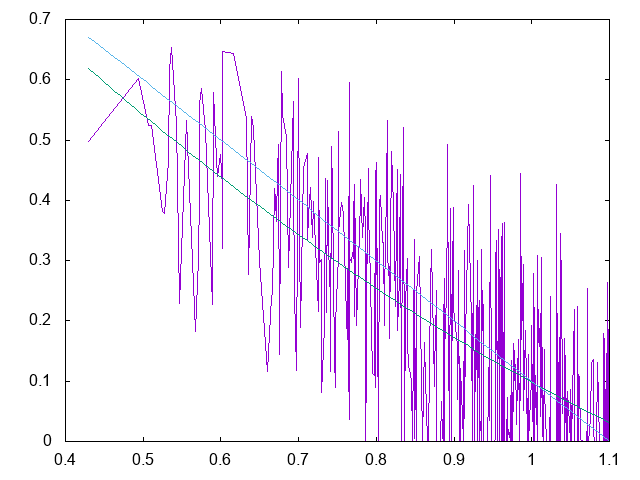

In [13]:
std::cout << "# fitted estimation \n  x_i \t   y_i  \t V(x_i) \n";
{
    std::vector<std::vector<double>> x(3),y(3);
    
    for(auto di : data)
    {
        x[0].push_back(di.x);y[0].push_back(di.y);
        std::cout << di.x << "\t " << di.y << "\t " << V(di.x) << "\n";
    }
    int steps=100;
    double xMin=data.begin()->x;
    double xMax=data.rbegin()->x;
    double xStep = (xMax-xMin)/steps;
    for(int i=0;i<=steps;i++)
    {
        double xVal=xMin + i*xStep;
        x[1].push_back(xVal);y[1].push_back(V(xVal));
        x[2].push_back(xVal);y[2].push_back(strikePrice - xVal);
    }
    GPLT::figure = GPLT::G.plotData(x,y,0);
}
GPLT::figure

In the figure, the purple line gives the particular value of continuing alaong a path, the green line plots the regression function $V(S)$, and the blue line plots the payoff function $X-S$.

This then allows you to decide at which points in time you would exercise and thus determine the cash flows at $t=2$ (below). Notice that for each path, if you exercise at $t=2$ then you do not
also exercise at $t=3$. The decision for a particular path is made by comparing the continuation value vs the exercise value __not__ the future value on that path vs the exercise value. In the picture it infers that any path at $t=2$ with $S<1$ will be exercised early.

In [14]:
std::cout << "# Cash flow at this step: \ni kstar  V \n";
// then select those paths and check against continuation function
for(int i=0;i<int(n);i++)
{
    std::cout << i+1 << " ";
    if(paths[i][2]<strikePrice)
    {
        double exerciseValue=std::max(strikePrice - paths[i][2],0.);
        if(exerciseValue>V(paths[i][2]))
        {
            exercisePeriod[i]=2;
            std::cout << exercisePeriod[i] << "     " << strikePrice - paths[i][2] << "\n";
        }
        else 
        {
            std::cout << exercisePeriod[i] << "     " << std::max(strikePrice - paths[i][3],0.)*exp(-interestRate*dt) << "\n";
        } 
    }
    else
    {
        std::cout << exercisePeriod[i] << "     " << std::max(strikePrice - paths[i][3],0.)*exp(-interestRate*dt) << "\n";
    }
}

# Cash flow at this step: 
i kstar  V 
1 3     0
2 2     0.330131
3 2     0.125538
4 3     0
5 2     0.0977496
6 2     0.527006
7 2     0.285921
8 3     0
9 3     0
10 2     0.286224
11 3     0
12 3     0
13 3     0
14 3     0
15 3     0
16 3     0.0804715
17 3     0
18 3     0
19 2     0.19119
20 2     0.525279
21 2     0.142209
22 2     0.403386
23 3     0
24 3     0.00129095
25 2     0.328145
26 3     0
27 2     0.497365
28 3     0
29 3     0
30 3     0.0857015
31 3     0.131411
32 3     0
33 2     0.11448
34 3     0
35 3     0
36 3     0.0318943
37 2     0.269797
38 3     0
39 2     0.349254
40 2     0.28259
41 3     0
42 2     0.181302
43 2     0.207969
44 2     0.232641
45 3     0
46 2     0.117434
47 3     0.238268
48 2     0.103922
49 3     0
50 3     0
51 2     0.211082
52 3     0
53 3     0.0727049
54 3     0
55 3     0
56 3     0
57 3     0
58 3     0
59 2     0.145208
60 3     0
61 3     0
62 2     0.127924
63 2     0.146073
64 2     0.413206
65 2     0.320622
66 3     0.12

590 2     0.371068
591 3     0.0813807
592 2     0.283072
593 2     0.505028
594 3     0.163823
595 2     0.258181
596 2     0.33446
597 3     0.134773
598 2     0.406075
599 2     0.353915
600 3     0
601 3     0
602 3     0
603 2     0.373134
604 3     0
605 2     0.141183
606 2     0.370256
607 3     0
608 3     0
609 3     0
610 3     0
611 2     0.312827
612 3     0.156388
613 3     0
614 3     0
615 3     0
616 2     0.110375
617 2     0.187376
618 2     0.173591
619 2     0.269293
620 2     0.327732
621 3     0
622 3     0
623 3     0.268933
624 3     0
625 2     0.263271
626 3     0
627 3     0
628 3     0.0508993
629 3     0
630 3     0
631 3     0.294167
632 3     0.0675538
633 2     0.244039
634 3     0
635 2     0.167258
636 3     0
637 2     0.51092
638 3     0
639 2     0.302164
640 3     0
641 2     0.144946
642 3     0
643 3     0
644 2     0.31012
645 2     0.132428
646 3     0
647 3     0
648 2     0.37544
649 2     0.215786
650 2     0.173989
651 3     0
652 3     0


We can apply the same process to $t=1$, for each of the paths that are in the money we regress the discounted future cash flows on the current value of the underlying asset, including any decisions we made to early exercise at $t=2$ in the calculation. We can then form a loop to go through each of the timesteps recurssively back to the initial start point. Finally the option can be valued by averaging the cashflows on each path.

In [15]:
// number of exercise dates
timeSteps=3;
M_degree=2;
// some parameters in the problem
maturity=3.;
interestRate=0.06;
strikePrice=1.1;
S0=1.;
// number of paths n
paths=MATH60082::generateLongstaffPaths(timeSteps,dt,n);
exercisePeriod = std::vector<int>(n,timeSteps);
   
    // assume that time period is t=2
    for(int k=timeSteps-1;k>=1;k--)
    { 
        // create an empty set of data points
        std::vector<MATH60082::DataPoint> data;
        data.reserve(paths.size());
        // go through each path, check if it is in the money
        // if it is add it as a datapoint with appropriate payoff
        for(int i=0;i<int(paths.size());i++)
        {
            if(paths[i][k]<strikePrice)
            {
                int kStar=exercisePeriod[i];
                double tStar=(kStar-k)*dt;
                data.push_back({paths[i][k],std::max(strikePrice - paths[i][kStar],0.)*exp(-interestRate*tStar),1.});
            }
        }
        
        // get the continuation function
        MATH60082::LeastSquaresFit V;      
        V.generateFit(M_degree,data);
        // then select those paths and check against continuation function
        for(int i=0;i<int(paths.size());i++)
        {
            if(paths[i][k]<strikePrice)
            {
                double exerciseValue=std::max(strikePrice - paths[i][k],0.);
                if(exerciseValue>V(paths[i][k]))
                {
                    exercisePeriod[i]=k;
                }
                else 
                {
                    int kStar=exercisePeriod[i];
                    double tStar=(kStar-k)*dt;
                } 
            }
            else
            {
                int kStar=exercisePeriod[i];
                double tStar=(kStar-k)*dt;
            }
        }
        
    }
    
    {
        // implement Monte Carlo on the paths
        double sum=0.;
        for(int i=0;i<n;i++)
        {
            // get early exercise time for American option
            int k=exercisePeriod[i];
            double exerciseValue=std::max(strikePrice - paths[i][k],0.);
            double exerciseTime=k*dt;
            sum+=exerciseValue*exp(-interestRate*exerciseTime);
        }
        std::cout << "\n#\n##\n# American Option Value is " << sum/n << "\n";
    }
    {
        // implement Monte Carlo on the paths
        double sum=0.;
        for(int i=0;i<n;i++)
        {
            // set exercise to final time step for European option
            int k=timeSteps;
            double exerciseValue=std::max(strikePrice - paths[i][k],0.);
            double exerciseTime=k*dt;
            sum+=exerciseValue*exp(-interestRate*exerciseTime);
        }
        std::cout << "\n#\n##\n# European Option Value is " << sum/n << "\n";
    }


#
##
# American Option Value is 0.114434

#
##
# European Option Value is 0.0563807


So the final value of the option we have for the American style option is 0.114434. If we were to use the exact same paths to value a European style option, we would just exercise all paths at maturity. The corresponding value is found here as 0.0563807, so that the value of the European is less than the value of the American -- which is what we would expect.

Finally we can put this in some code and run some analysis as to what happens as $N\rightarrow\infty$. To analyse the values we might like something to compare against. You can use the calculator on my webpage [(click here)](https://personalpages.manchester.ac.uk/staff/paul.johnson-2/pages/americanCalculator.html) to get reference values. Choosing $S_0=1.973$, $T=1$, $X=2$, $r=0.05$, $\sigma=0.4$ we have an American option value of $V=0.284$. Running our Monte Carlo code appears to converge on a similar result:-

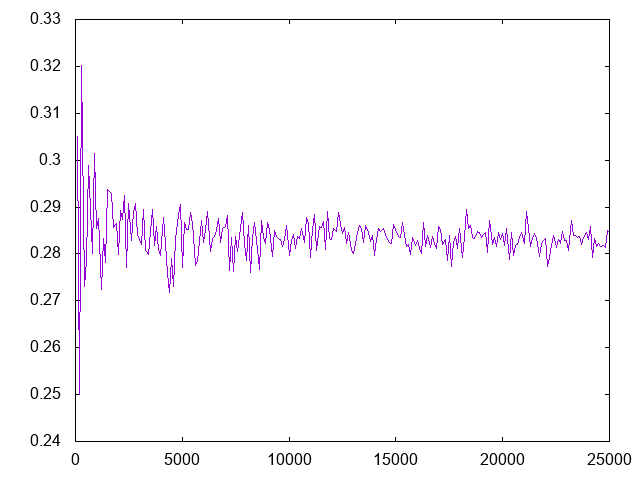

In [16]:
{
    // number of exercise dates
    int timeSteps=10; 
    // some parameters in the problem
    double maturity=1.,interestRate=0.05,strikePrice=2.,S0=1.973,sigma=0.4;
    
    // number of paths n
    int n=100;
    // degree of fitting polynomial
    int M_degree=4;
    
    int simulations=250;
    std::vector<double> steps(simulations),values(simulations);
    
    for(int i=0;i<simulations;i++)
    {
        int N=(i+1)*n;
        steps[i] = N;
        values[i] = MATH60082::monteCarloLeastSquares(S0,maturity,strikePrice,interestRate,sigma,timeSteps,M_degree,N);
    }
    GPLT::figure = GPLT::G.plotData(steps,values,0);
}
GPLT::figure